In [28]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """
    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

Toggle code

In [ ]:
import os
import ee
import geemap
import ipywidgets as widgets
import ipyleaflet
from ipyleaflet import WidgetControl
import geopandas as gpd
import geemap.chart as chart
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import ipympl
#import warnings
#warnings.filterwarnings("ignore")
#import geemap.foliumap as geemap

In [2]:
from ipyleaflet import (
Map, basemaps, basemap_to_tiles,
WMSLayer, LayersControl
)

In [3]:
Map = geemap.Map(center=(40, -100), zoom=4)
#Map

In [4]:
# Add Earth Engine dataset
#dem = ee.Image('USGS/SRTMGL1_003')

# VIIRS Night time light example
#viirs2018= ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2018-01-01","2018-12-31").select('avg_rad').median().
#poi = ee.Geometry.Point(127.072483, 37.515817).buffer(500)
viirs_map = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2020-12-31').select('avg_rad')

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2014-01-01','2020-12-31')

Map.add_basemap('SATELLITE')

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Add Earth Eninge layers to Map
Map.addLayer(viirs_map, vis_params, 'VIIRS map', True, 0.7)

In [5]:
# define and costumize the panel for widget visualization/output 

output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = WidgetControl(widget=output_widget, position='bottomright')
Map.add_control(output_control)

In [7]:
style = {'description_width': 'initial'}
uploader = widgets.FileUpload(
    description='Upload data',
    accept='.zip, .json, .geojson, .shp', 
    multiple=False,
    button_style='primary',
    style=style
)

submit = widgets.Button(
    description='Display data',
    button_style='success',
    tooltip='Click me',
    style=style)

reset = widgets.Button(
    description='Reset',
    button_style='warning',
    tooltip='Click me',
    style=style)

plot = widgets.Button(
    description='Plotting',
    button_style='warning',
    tooltip='Click me',
    style=style)

In [8]:
with output_widget:
    print('Upload shapefile or \ngeojson as a zip file')
    display(uploader)
    display(submit)
    display(reset)
    display(plot)

In [9]:
# get the vector loaded through the output widget 

def get_vector(upload_widget, out_dir=None):
    
    import zipfile
    import glob
    
    if out_dir is None:
        out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    vector = None
    
    try:    
        [uploaded_file] = upload_widget.value
        file = upload_widget.value[uploaded_file]
        name = file['metadata']['name']
        content = file['content']
        out_file = os.path.join(out_dir, name)
        with open(out_file, "wb") as fp:
            fp.write(content)

        if name.endswith('.zip'):
            with zipfile.ZipFile(out_file, "r") as zip_ref:
                extract_dir = os.path.join(out_dir, name[:-4] + "_" + geemap.random_string(3))
                zip_ref.extractall(extract_dir)
                files = glob.glob(extract_dir + '/*.shp')
                if len(files) > 0:
                    shp = files[0]
                    vector = geemap.shp_to_ee(shp)
                else:
                    files = glob.glob(extract_dir + '/*.geojson')
                    if len(files) > 0:
                        geojson = files[0]
                        vector = geemap.geojson_to_ee(geojson)
        else:
            vector = geemap.geojson_to_ee(out_file)
                                
    except Exception as e:
        print(e)

    return vector

In [10]:
def submit_clicked(b):
    if uploader._counter > 0:
        Map.default_style = {'cursor': 'wait'}        
        try:
            fc = get_vector(uploader)
            layer_name = 'Layer ' + geemap.random_string(3)
            Map.addLayer(fc, {}, layer_name)
            Map.centerObject(fc)
            uploader.value.clear()
            uploader._counter = 0    
        except Exception as e:
            print(e)
        Map.default_style = {'cursor': 'pointer'}

submit.on_click(submit_clicked)

def reset_clicked(b):

    Map.layers = Map.layers[:3]
    output_widget.clear_output()
    with output_widget:
        print('Upload shapefile or \ngeojson as a zip file')
        display(uploader)
        display(submit)
        display(reset)
    uploader.value.clear()
    uploader._counter = 0
    
reset.on_click(reset_clicked)

In [11]:
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [15]:
region = get_vector(uploader)

In [16]:
def region_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=region, scale=30).get('avg_rad')
    return img.set('date', img.date().format()).set('mean',mean)

In [17]:
region_reduced_imgs = viirs.map(region_mean)


In [18]:
nested_list = region_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [19]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
df['date'] = pd.to_datetime(df['date'])

#df = df.set_index('date')
df.head()

,date,mean
0,2014-01-01,49.701630
1,2014-02-01,52.887593
2,2014-03-01,53.543461
3,2014-04-01,52.898194
4,2014-05-01,45.928226


In [ ]:
### Chart Time serie VIIRS

In [20]:
%matplotlib widget


#output_widget_chart.clear_output()
output_widget_chart = widgets.Output(layout={'border': '1px solid black'})
output_control_chart = ipyleaflet.WidgetControl(widget=output_widget_chart, position='topleft')
Map.add_control(output_control_chart)
with output_widget_chart:
#Map.add_control(output_control_chart)
#with output:
    with plt.style.context("ggplot"):
        fig = plt.figure(figsize=(5,2))

        plt.plot(df["date"].values, df["mean"].values)

        plt.xlabel("Date")
        plt.ylabel("Night Time Lights")
        plt.title("Line Chart for Night Time Lights");

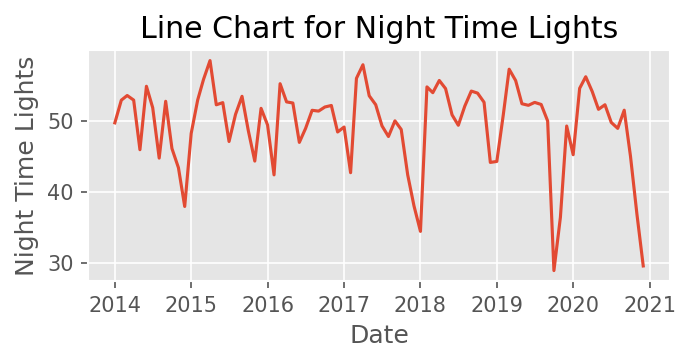

In [21]:
fig

In [22]:
#output_widget_chart.clear_output()
#output_widget_chart = widgets.Output(layout={'border': '1px solid black'})
#output_control_chart = ipyleaflet.WidgetControl(widget=output_widget_chart, position='topleft')
with output_widget_chart:
    display(fig)

In [24]:
#import geemap.foliumap as geemap
#import datapane as dp
#datapane login --token="96db988bbab0895446658094f32522f1f13a21c8"
#dp.ping()

In [ ]:

Map.publish(name='VIIRS', description='Web App Night Time Lights - VIIRS with Python')


In [25]:
Map

Map(bottom=180552.0, center=[48.90992, 2.44572], controls=(WidgetControl(options=['position', 'transparent_bg'…